In [1]:
# ncf-py39.ipynb

# Разработка рекомендательной системы для электронной коммерции на основе гибридного подхода машинного обучения с учётом пользовательского поведения и контентных характеристик

In [3]:
#import os
#os.chdir('..')
import sys
import numpy as np
import pandas as pd
import plotly.express as px
import time
import warnings
import random
warnings.simplefilter("ignore")
from tqdm.notebook import tqdm
#from tqdm import tqdm
warnings.simplefilter("ignore")
from settings import *
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
import pickle
import tensorflow as tf
import random
tf.get_logger().setLevel('ERROR') # only show error messages

In [4]:
start_time = time.time()

In [5]:
#import tensorflow.compat.v1 as tf
print(f'System version: {sys.version}')
print(f'Pandas version: {pd.__version__}')

System version: 3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.5.3


In [6]:
def toratings(ds):
    """
    Преобразует таблицу к строкам: user_id, category_name, rating и надо добавить timestamp
    """
    cols = np.sort(dataset[SPLIT_CATEGORY].unique()).tolist() # Получаем значения всех категорий
    #ds = ds.loc[:, (ds != 0).any(axis=0)] # Удаляем столбцы с одними нулями
    ds.reset_index(inplace=True) # Преобразуем индекс в столбец

    ratings = pd.DataFrame()
    for col in cols:
        if col not in list(ds.columns):
            cols.remove(col)
    for col in cols:
        dtmp = ds[ds[col]!=0][['user_id', col, 'last_purchase']].rename(columns={col: 'rating'})
        dtmp.insert(1,'category',col)
        ratings=pd.concat([ratings,dtmp], ignore_index = True)
    df2 = pd.to_datetime(ratings['last_purchase'])
    ratings['last_purchase'] = df2
    ratings['itemID'] = pd.factorize(ratings['category'])[0]
    print(ratings.head(1))
    return ratings.rename(columns={'last_purchase': 'timestamp', 'user_id': 'userID'})

In [7]:
# Model parameters
# top k items to recommend
TOP_K = 5

EPOCHS = 100
BATCH_SIZE = 256

SEED = 42

In [8]:
# Evaluate how well NCF performs
# The ranking metrics are used for evaluation.
def eval_ncf():
    #TOP_K = 10
    #df_merge["top_k"] = k
    #df_merge["denominator"] = df_merge[["top_k", "actual"]].min(axis=1)
    #eval_map = (df_merge["rr"] / df_merge["denominator"]).sum() / n_users

    eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

    print("MAP:\t\t%f" % eval_map,
          "NDCG:\t\t%f" % eval_ndcg,
          "Precision@K:\t%f" % eval_precision,
          "Recall@K:\t%f" % eval_recall, sep='\n')
    return [eval_map, eval_ndcg, eval_precision, eval_recall]

In [9]:
pd.options.display.float_format = "{:,.2f}".format
prec = []

In [10]:
%%time
# 1h 39min 3s
random.seed(42)
dataset = pd.read_pickle(ds_flt_file) # Полные данные после фильтрации
ds = pd.read_pickle(showcase_seg_file) # Сегментированная витрина
prec = []
for seg in set(ds['Segment']):
    df = ds[ds['Segment']==seg].copy()
    df.reset_index('user_id', inplace=True)
    df = dataset[(dataset['event_type'] == 'purchase') & (dataset['user_id'].isin(df['user_id']))][['user_id', 'category_code_level2', 'event_time']]
    df['rating'] = 1
    df.rename(columns = {'user_id': 'userID', 'category_code_level2': 'category', 'event_time': 'timestamp'}, inplace=True)
    factor = pd.factorize(df['category'])
    df['itemID'] = factor[0]
    # Split the data using the Spark chronological splitter provided in utilities
    train, test = python_chrono_split(df, ratio = 0.75)
    
    # Filter out any users or items in the test set that do not appear in the training set.
    test = test[test["userID"].isin(train["userID"].unique())]
    test = test[test["itemID"].isin(train["itemID"].unique())]
    
    # Write datasets to csv files.
    train_file = cache_dir + "./train.csv"
    test_file = cache_dir + "./test.csv"
    train.to_csv(train_file, index=False)
    test.to_csv(test_file, index=False)

    # Generate an NCF dataset object from the data subsets.
    data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED)
    
    model = NCF(
        n_users=data.n_users, 
        n_items=data.n_items,
        model_type="mlp",
        #n_factors=4,
        n_factors=8,
        layer_sizes=[16,8,4],
        n_epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=1e-3, # Было 1e-3
        verbose=0,
        seed=SEED
    )
    
    with Timer() as train_time:
        model.fit(data)
    print(f'Took {train_time} seconds for training.')
    # Plot the train RMSE as a function of the epochs
    dir('model')
    #line_graph(values=model.data, labels='train', x_name='epoch', y_name='rmse_train');
    
    with Timer() as test_time:
        users, items, preds = [], [], []
        item = list(train.itemID.unique())
        for user in train.userID.unique():
            user = [user] * len(item) 
            users.extend(user)
            items.extend(item)
            preds.extend(list(model.predict(user, item, is_list=True)))

        all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

        merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
        all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
    print(f'Took {test_time} seconds for prediction.')
    
    prec.append(eval_ncf())
    # Train the NCF model
    print(f'\nСегмент: {seg}')
    for n in random.sample(range(0, len(all_predictions)), 2):
    #for n in [0, 100]:
        user_id = all_predictions['userID'].iloc[n]
        print(f'Пользователь: {user_id}')
        print(f'Рекомендовано: {[factor[1][idx] for idx in all_predictions[all_predictions["userID"]==user_id].sort_values("prediction",ascending = False).head(5)["itemID"]]}')
        print(f'Куплено: {set(dataset[(dataset["user_id"]==user_id) & (dataset["event_type"]=="purchase")]["category_code_level2"])}\n')

prec = pd.DataFrame(prec, columns=['MAP', 'NDCG', 'Precision@K', 'Recall@K'])
prec.index.name = 'Segment'

INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [0.81s]: train_loss = 0.692951 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [0.80s]: train_loss = 0.692693 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [0.70s]: train_loss = 0.692429 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [0.67s]: train_loss = 0.692160 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [0.68s]: train_loss = 0.691820 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [0.67s]: train_loss = 0.691476 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [0.70s]: train_loss = 0.691086 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [0.82s]: train_loss = 0.690700 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [0.67s]: train_loss = 0.690256 
INFO:recommenders.models.ncf.nc

Took 162.0439 seconds for training.
Took 0.4463 seconds for prediction.
MAP:		0.048621
NDCG:		0.061034
Precision@K:	0.023944
Recall@K:	0.099178

Сегмент: 0
Пользователь: 515472057
Рекомендовано: ['water_heater', 'notebook', 'tv', 'desktop', 'microwave']
Куплено: {'subwoofer'}

Пользователь: 564407689
Рекомендовано: ['subwoofer', 'water_heater', 'tv', 'microwave', 'kettle']
Куплено: {'desktop', 'notebook'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [2.91s]: train_loss = 0.692719 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [2.72s]: train_loss = 0.692011 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [2.76s]: train_loss = 0.691114 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [2.65s]: train_loss = 0.690074 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [2.82s]: train_loss = 0.688967 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [2.83s]: train_loss = 0.687947 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [2.77s]: train_loss = 0.686913 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [2.90s]: train_loss = 0.685907 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [2.52s]: train_loss = 0.684936 
INFO:recommenders.models.ncf.nc

Took 541.0040 seconds for training.
Took 1.5822 seconds for prediction.
MAP:		0.034307
NDCG:		0.046000
Precision@K:	0.018234
Recall@K:	0.077754

Сегмент: 1
Пользователь: 554150434
Рекомендовано: ['tv', 'shoes', 'blender', 'kettle', 'headphone']
Куплено: {'video', 'dolls', 'desktop'}

Пользователь: 547667040
Рекомендовано: ['tv', 'shoes', 'desktop', 'blender', 'kettle']
Куплено: {'refrigerators', 'headphone'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [0.82s]: train_loss = 0.693124 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [0.67s]: train_loss = 0.692892 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [0.66s]: train_loss = 0.692658 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [0.79s]: train_loss = 0.692375 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [0.67s]: train_loss = 0.692086 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [0.65s]: train_loss = 0.691779 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [0.66s]: train_loss = 0.691420 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [0.66s]: train_loss = 0.691030 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [0.69s]: train_loss = 0.690664 
INFO:recommenders.models.ncf.nc

Took 137.1101 seconds for training.
Took 0.4067 seconds for prediction.
MAP:		0.063945
NDCG:		0.089977
Precision@K:	0.039057
Recall@K:	0.155163

Сегмент: 2
Пользователь: 523369625
Рекомендовано: ['monitor', 'headphone', 'keyboard', 'memory', 'mouse']
Куплено: {'power_supply', 'videocards', 'motherboard', 'memory', 'cpu', 'cooler', 'hdd'}

Пользователь: 547867073
Рекомендовано: ['monitor', 'headphone', 'videocards', 'hdd', 'keyboard']
Куплено: {'cpu'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [29.55s]: train_loss = 0.692201 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [30.77s]: train_loss = 0.689421 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [30.18s]: train_loss = 0.686648 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [29.99s]: train_loss = 0.683823 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [29.94s]: train_loss = 0.680807 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [30.25s]: train_loss = 0.677647 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [32.28s]: train_loss = 0.674339 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [31.43s]: train_loss = 0.670966 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [30.37s]: train_loss = 0.667498 
INFO:recommenders.mode

Took 5317.1808 seconds for training.
Took 2.7431 seconds for prediction.
MAP:		0.040074
NDCG:		0.046272
Precision@K:	0.015760
Recall@K:	0.060122

Сегмент: 3
Пользователь: 527724957
Рекомендовано: ['headphone', 'tv', 'clocks', 'tablet', 'air_heater']
Куплено: {'tablet', 'notebook'}

Пользователь: 528007298
Рекомендовано: ['tv', 'clocks', 'notebook', 'tablet', 'air_heater']
Куплено: {'headphone'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [0.95s]: train_loss = 0.692882 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [0.86s]: train_loss = 0.692570 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [0.85s]: train_loss = 0.692201 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [0.97s]: train_loss = 0.691836 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [0.82s]: train_loss = 0.691409 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [0.82s]: train_loss = 0.690949 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [0.83s]: train_loss = 0.690471 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [0.84s]: train_loss = 0.689960 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [1.03s]: train_loss = 0.689449 
INFO:recommenders.models.ncf.nc

Took 179.0971 seconds for training.
Took 0.6025 seconds for prediction.
MAP:		0.119703
NDCG:		0.142084
Precision@K:	0.046231
Recall@K:	0.201633

Сегмент: 4
Пользователь: 516788209
Рекомендовано: ['hob', 'oven', 'hood', 'vacuum', 'kettle']
Куплено: {'grill'}

Пользователь: 514644510
Рекомендовано: ['oven', 'hood', 'vacuum', 'grill', 'kettle']
Куплено: {'hob'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [0.44s]: train_loss = 0.693074 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [0.30s]: train_loss = 0.692947 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [0.30s]: train_loss = 0.692793 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [0.30s]: train_loss = 0.692600 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [0.42s]: train_loss = 0.692425 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [0.30s]: train_loss = 0.692272 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [0.28s]: train_loss = 0.692015 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [0.29s]: train_loss = 0.691798 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [0.30s]: train_loss = 0.691641 
INFO:recommenders.models.ncf.nc

Took 60.1040 seconds for training.
Took 0.2252 seconds for prediction.
MAP:		0.115489
NDCG:		0.133785
Precision@K:	0.045652
Recall@K:	0.179348

Сегмент: 5
Пользователь: 515160978
Рекомендовано: ['dishwasher', 'refrigerators', 'air_conditioner', 'washer', 'tv']
Куплено: {'oven', 'telephone'}

Пользователь: 556761274
Рекомендовано: ['dishwasher', 'refrigerators', 'air_conditioner', 'oven', 'washer']
Куплено: {'chair', 'iron', 'headphone'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [8.30s]: train_loss = 0.692844 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [8.51s]: train_loss = 0.691388 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [8.08s]: train_loss = 0.689710 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [8.80s]: train_loss = 0.688106 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [8.44s]: train_loss = 0.686545 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [8.80s]: train_loss = 0.684990 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [8.39s]: train_loss = 0.683387 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [8.18s]: train_loss = 0.681743 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [8.42s]: train_loss = 0.680015 
INFO:recommenders.models.ncf.nc

Took 2005.1021 seconds for training.
Took 2.5947 seconds for prediction.
MAP:		0.065619
NDCG:		0.081257
Precision@K:	0.028738
Recall@K:	0.125528

Сегмент: 6
Пользователь: 537596413
Рекомендовано: ['vacuum', 'tv', 'iron', 'microwave', 'oven']
Куплено: {'refrigerators', 'washer'}

Пользователь: 557222475
Рекомендовано: ['vacuum', 'refrigerators', 'tv', 'iron', 'oven']
Куплено: {'microwave', 'washer'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [2.48s]: train_loss = 0.692890 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [1.85s]: train_loss = 0.692579 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [1.80s]: train_loss = 0.692253 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [0.82s]: train_loss = 0.691846 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [0.77s]: train_loss = 0.691415 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [0.93s]: train_loss = 0.690930 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [0.70s]: train_loss = 0.690435 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [0.77s]: train_loss = 0.689896 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [0.70s]: train_loss = 0.689376 
INFO:recommenders.models.ncf.nc

Took 183.3418 seconds for training.
Took 0.5453 seconds for prediction.
MAP:		0.082671
NDCG:		0.093122
Precision@K:	0.030303
Recall@K:	0.114646

Сегмент: 7
Пользователь: 516283737
Рекомендовано: ['subwoofer', 'player', 'drill', 'diapers', 'alarm']
Куплено: {'table', 'chair'}

Пользователь: 566141709
Рекомендовано: ['subwoofer', 'player', 'diapers', 'alarm', 'videoregister']
Куплено: {'drill', 'headphone'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [1.29s]: train_loss = 0.692713 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [1.19s]: train_loss = 0.692287 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [1.21s]: train_loss = 0.691835 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [1.33s]: train_loss = 0.691239 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [1.28s]: train_loss = 0.690655 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [1.23s]: train_loss = 0.690010 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [1.30s]: train_loss = 0.689354 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [1.38s]: train_loss = 0.688652 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [1.31s]: train_loss = 0.688078 
INFO:recommenders.models.ncf.nc

Took 238.7026 seconds for training.
Took 0.6431 seconds for prediction.
MAP:		0.067666
NDCG:		0.080545
Precision@K:	0.028049
Recall@K:	0.113991

Сегмент: 8
Пользователь: 527212331
Рекомендовано: ['washer', 'printer', 'water_heater', 'notebook', 'videoregister']
Куплено: {'air_heater'}

Пользователь: 523955580
Рекомендовано: ['printer', 'notebook', 'videoregister', 'refrigerators', 'scales']
Куплено: {'washer', 'iron', 'water_heater', 'toilet'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [2.41s]: train_loss = 0.692849 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [2.16s]: train_loss = 0.692192 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [2.32s]: train_loss = 0.691370 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [2.19s]: train_loss = 0.690412 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [2.29s]: train_loss = 0.689437 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [2.18s]: train_loss = 0.688501 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [2.17s]: train_loss = 0.687600 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [2.31s]: train_loss = 0.686707 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [2.17s]: train_loss = 0.685843 
INFO:recommenders.models.ncf.nc

Took 488.9441 seconds for training.
Took 0.8157 seconds for prediction.
MAP:		0.066729
NDCG:		0.081102
Precision@K:	0.030127
Recall@K:	0.116068

Сегмент: 9
Пользователь: 554478457
Рекомендовано: ['telephone', 'headphone', 'player', 'meat_grinder', 'notebook']
Куплено: {'keds'}

Пользователь: 513665518
Рекомендовано: ['headphone', 'player', 'keds', 'notebook', 'meat_grinder']
Куплено: {'washer', 'telephone'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [0.49s]: train_loss = 0.692992 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [0.39s]: train_loss = 0.692787 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [0.38s]: train_loss = 0.692570 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [0.49s]: train_loss = 0.692333 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [0.37s]: train_loss = 0.692066 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [0.37s]: train_loss = 0.691803 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [0.37s]: train_loss = 0.691496 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [0.37s]: train_loss = 0.691184 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [0.37s]: train_loss = 0.690840 
INFO:recommenders.models.ncf.nc

Took 79.5301 seconds for training.
Took 0.5325 seconds for prediction.
MAP:		0.040504
NDCG:		0.059540
Precision@K:	0.028571
Recall@K:	0.102183

Сегмент: 10
Пользователь: 544720884
Рекомендовано: ['vacuum', 'headphone', 'sewing_machine', 'coffee_machine', 'blender']
Куплено: {'hob', 'washer', 'refrigerators', 'air_heater'}

Пользователь: 540075230
Рекомендовано: ['vacuum', 'headphone', 'coffee_machine', 'sewing_machine', 'blender']
Куплено: {'printer', 'grill'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [2.61s]: train_loss = 0.692857 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [1.83s]: train_loss = 0.692453 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [1.07s]: train_loss = 0.691919 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [2.00s]: train_loss = 0.691320 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [1.98s]: train_loss = 0.690669 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [1.43s]: train_loss = 0.689921 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [1.01s]: train_loss = 0.689197 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [0.99s]: train_loss = 0.688499 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [0.96s]: train_loss = 0.687792 
INFO:recommenders.models.ncf.nc

Took 229.9837 seconds for training.
Took 0.7420 seconds for prediction.
MAP:		0.061251
NDCG:		0.081149
Precision@K:	0.037137
Recall@K:	0.129819

Сегмент: 11
Пользователь: 539906412
Рекомендовано: ['clocks', 'tv', 'headphone', 'shoes', 'notebook']
Куплено: {'alarm'}

Пользователь: 560722040
Рекомендовано: ['clocks', 'tv', 'headphone', 'shoes', 'notebook']
Куплено: {'alarm', 'videoregister'}



INFO:recommenders.models.ncf.dataset:Indexing .\cache\./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing .\cache\./test_full.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [0.58s]: train_loss = 0.692995 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [0.48s]: train_loss = 0.692821 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [0.48s]: train_loss = 0.692651 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [0.48s]: train_loss = 0.692388 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [0.46s]: train_loss = 0.692257 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [0.47s]: train_loss = 0.692007 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [0.59s]: train_loss = 0.691773 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [0.46s]: train_loss = 0.691558 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [0.48s]: train_loss = 0.691244 
INFO:recommenders.models.ncf.nc

Took 120.6488 seconds for training.
Took 0.2986 seconds for prediction.
MAP:		0.030186
NDCG:		0.040350
Precision@K:	0.018026
Recall@K:	0.070815

Сегмент: 12
Пользователь: 555134241
Рекомендовано: ['saw', 'headphone', 'toys', 'generator', 'bicycle']
Куплено: {'carriage'}

Пользователь: 533697436
Рекомендовано: ['carriage', 'saw', 'headphone', 'toys', 'generator']
Куплено: {'microwave'}

CPU times: total: 2h 43min 58s
Wall time: 2h 43min 33s


In [11]:
from user_func import prdf
prec.index.name = 'Segment'
print('Метрики ранжирования')
prdf(prec.T)
for col in prec.columns:
    print(col, prec[col].mean())

Метрики ранжирования


Segment,0,1,2,3,4,5,6,7,8,9,10,11,12
MAP,0.05,0.03,0.06,0.04,0.12,0.12,0.07,0.08,0.07,0.07,0.04,0.06,0.03
NDCG,0.06,0.05,0.09,0.05,0.14,0.13,0.08,0.09,0.08,0.08,0.06,0.08,0.04
Precision@K,0.02,0.02,0.04,0.02,0.05,0.05,0.03,0.03,0.03,0.03,0.03,0.04,0.02
Recall@K,0.10,0.08,0.16,0.06,0.20,0.18,0.13,0.11,0.11,0.12,0.10,0.13,0.07


MAP 0.06436650408097525
NDCG 0.07970916097007191
Precision@K 0.029986872401082887
Recall@K 0.11894223248313633


In [12]:
seconds=int(time.time() - start_time)
print("%d:%02d" % (seconds//60, seconds-60*(seconds//60),))

163:33


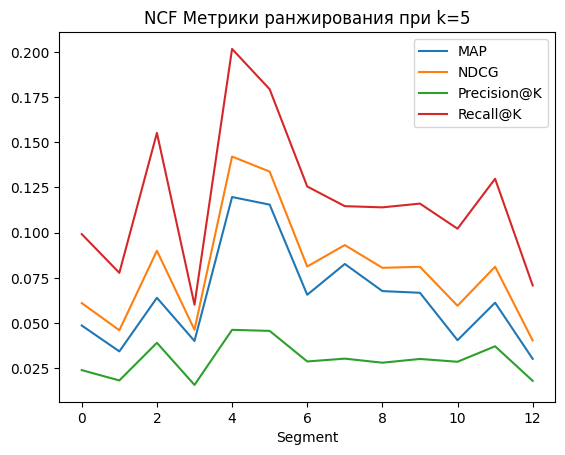

In [13]:
plot = prec.plot(title=f'NCF Метрики ранжирования при k={TOP_K}')
fig = plot.get_figure()
fig.savefig(f'ncfk{TOP_K}.png', dpi=300, bbox_inches='tight')